In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pathlib
import PIL
from PIL import Image
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pd.set_option('display.max_columns', None)

#Exploratory Data Analysis

In [2]:
# Class Labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [3]:
meta_df = pd.read_csv('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta.csv')

In [4]:
meta_df.sample(3)

Path  ClassId  ShapeId  ColorId SignId
0   Meta/27.png       27        0        0   1.32
20  Meta/26.png       26        0        0   1.24
41   Meta/8.png        8        1        0   3.29

In [5]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     43 non-null     object
 1   ClassId  43 non-null     int64 
 2   ShapeId  43 non-null     int64 
 3   ColorId  43 non-null     int64 
 4   SignId   42 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.8+ KB


In [6]:
test_df = pd.read_csv('C:/Users/HP/Documents/Codebasics/GTSCDS/Test.csv')

In [7]:
test_df.sample(3)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
10153    125     113      11      10     114     104       13  Test/10153.png
10670     36      33       6       5      31      28       28  Test/10670.png
3140      92      94       8       8      84      86        5  Test/03140.png

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [9]:
test_df['ClassId'] = test_df['ClassId'].astype(int)
test_df['Class_Label'] = test_df['ClassId'].map(classes)

In [10]:
test_df.sample(2)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path  \
361       38      73       5       7      32      67       38  Test/00361.png   
10162     44      42       6       5      39      37        2  Test/10162.png   

                Class_Label  
361              Keep right  
10162  Speed limit (50km/h)

In [11]:
fig = px.bar(test_df['Class_Label'].value_counts().reset_index(), x = 'Class_Label', y = 'count',
             width = 900, height = 700, labels = {'ClassId': 'Class Label', 'count': 'Number of images'}, title = 'Test image class distribution')
fig.show()

In [12]:
train_df = pd.read_csv('C:/Users/HP/Documents/Codebasics/GTSCDS/Train.csv')

In [13]:
train_df.sample(3)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
6422      29      28       6       6      24      23        3   
27910     42      38       5       5      37      33       23   
10049     74      74       6       7      68      68        5   

                                 Path  
6422    Train/3/00003_00046_00002.png  
27910  Train/23/00023_00007_00010.png  
10049   Train/5/00005_00053_00029.png

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [15]:
train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df['Class_Label'] = train_df['ClassId'].map(classes)

In [16]:
train_df.sample(2)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
12398     35      34       6       5      30      29        8   
38663     64      65       5       6      59      60       40   

                                 Path            Class_Label  
12398   Train/8/00008_00008_00008.png  Speed limit (120km/h)  
38663  Train/40/00040_00009_00024.png   Roundabout mandatory

In [17]:
fig = px.bar(train_df['Class_Label'].value_counts().reset_index(), x = 'Class_Label', y = 'count',
             width = 1100, height = 700, labels = {'ClassId': 'Class Label', 'count': 'Number of images'}, title = 'Train image class distribution')
fig.show()

In [18]:
data_dir = pathlib.Path("C:/Users/HP/Documents/Codebasics/GTSCDS")
data_dir

WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS')

In [19]:
list(data_dir.rglob('*/*.png'))[:5]

[WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/0.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/1.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/10.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/11.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/12.png')]

In [20]:
print('Total number of images: {}'.format(len(list(data_dir.rglob('*/*.png')))))

Total number of images: 109425


In [21]:
list(data_dir.rglob('Meta/*'))[:5]

[WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/.~lock.ClassesInformation.ods#'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/.~lock.ClassesInformationStrong.ods#'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/0.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/1.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Meta/10.png')]

In [22]:
print('Number of Meta images: {}'.format(len(list(data_dir.rglob('Meta/*.png')))))

Number of Meta images: 43


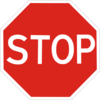

In [23]:
metl = list(data_dir.rglob('Meta/*'))
PIL.Image.open(str(random.choice(metl)))

In [24]:
list(data_dir.rglob('Test/*'))[:5]

[WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Test/00000.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Test/00001.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Test/00002.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Test/00003.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Test/00004.png')]

In [25]:
print('Number of Test images: {}'.format(len(list(data_dir.rglob('Test/*.png')))))

Number of Test images: 12630


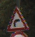

In [26]:
tesl = list(data_dir.rglob('Test/*'))
PIL.Image.open(str(random.choice(tesl)))

In [27]:
list(data_dir.glob('Train/*'))[:5]

[WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Train/0'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Train/1'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Train/10'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Train/11'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/Train/12')]

In [28]:
len(list(data_dir.glob('Train/*')))

43

In [29]:
tl = list(data_dir.glob('Train/*'))
tdict = {}
for i in tl:
  tdict[i.name] = len(list(i.glob('*.png')))

In [30]:
tdict

{'0': 210,
 '1': 2220,
 '10': 2010,
 '11': 1320,
 '12': 2100,
 '13': 2160,
 '14': 780,
 '15': 630,
 '16': 420,
 '17': 1110,
 '18': 1200,
 '19': 210,
 '2': 2250,
 '20': 360,
 '21': 330,
 '22': 390,
 '23': 510,
 '24': 270,
 '25': 1500,
 '26': 600,
 '27': 240,
 '28': 540,
 '29': 270,
 '3': 1410,
 '30': 450,
 '31': 780,
 '32': 240,
 '33': 689,
 '34': 420,
 '35': 1200,
 '36': 390,
 '37': 210,
 '38': 2070,
 '39': 300,
 '4': 1980,
 '40': 360,
 '41': 240,
 '42': 240,
 '5': 1860,
 '6': 420,
 '7': 1440,
 '8': 1410,
 '9': 1470}

In [31]:
print('Number of Train images: {}'.format(sum(tdict.values())))

Number of Train images: 39209


In [32]:
tral = list(data_dir.glob('Train/*'))

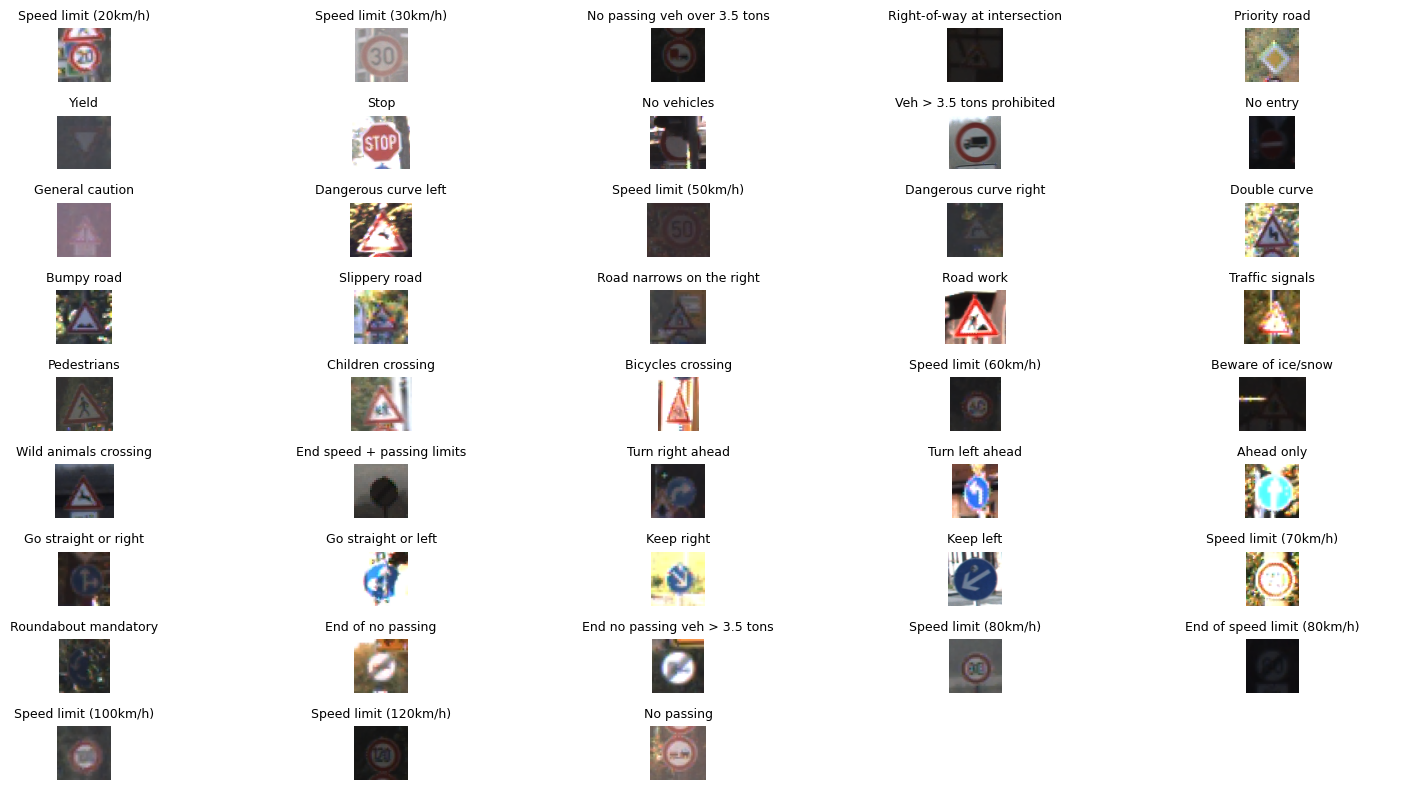

In [33]:
images_per_row = 5

fig, axes = plt.subplots(
    nrows = (len(tral) + images_per_row - 1) // images_per_row,
    ncols = images_per_row,
    figsize = (15, 8)
)
axes = axes.flatten()

for idx, folder in enumerate(tral):
    for image_path in folder.glob('*.png'):
        img = Image.open(image_path)
        axes[idx].imshow(img)
        label = classes.get(int(folder.name), f"Class {folder.name}")
        axes[idx].set_title(label, fontsize=9)
        axes[idx].axis('off')
        break
for ax in axes[len(tral):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


#Data Augmentation

In [34]:
max(tdict.values())

2250

In [35]:
min(tdict.values())

210

In [36]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    fill_mode = 'nearest'
)

datagen2 = ImageDataGenerator(
    rotation_range = 8,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = False,
    fill_mode = 'nearest'
)

In [37]:
augmented_dir = pathlib.Path('C:/Users/HP/Documents/Codebasics/GTSCDS/TrafficAugmented')
tl = list(data_dir.glob('Train/*'))

for i in tl:
  l1 = list(i.glob('*.png'))
  if len(l1) <= max(tdict.values()) :

      folder = augmented_dir / i.name
      limit = max(tdict.values()) - len(l1)
      print(i, limit)

      if int(i.name) not in [19, 20, 33, 34, 36, 37, 38, 39] :
        tl2 = list(folder.glob('*.png'))
        slots = limit - len(tl2)

        while len(tl2) < limit :
          sam = random.choice(l1)
          img_name = sam.name
          img = image.load_img(sam, target_size = (62, 62))
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis = 0)

          aug_iter = datagen.flow(img_array, batch_size = random.randint(1, min(slots, 10)), save_to_dir = str(augmented_dir) + '/' + str(i.name),
                                    save_prefix = 'class' + '|' + str(i.name) + '|' + img_name.split('.')[0], save_format = 'png')
          next(aug_iter)

          tl2 = list(folder.glob('*.png'))

      else :
        tl2 = list(folder.glob('*.png'))
        slots = limit - len(tl2)

        while len(tl2) < limit :
          sam = random.choice(l1)
          img_name = sam.name
          img = image.load_img(sam, target_size = (62, 62))
          img_array = image.img_to_array(img)
          img_array = np.expand_dims(img_array, axis = 0)

          aug_iter = datagen2.flow(img_array, batch_size = random.randint(1, min(slots, 10)), save_to_dir = str(augmented_dir) + '/' + str(i.name),
                                    save_prefix = 'class' + '|' + str(i.name) + '|' + img_name.split('.')[0], save_format = 'png')
          next(aug_iter)

          tl2 = list(folder.glob('*.png'))

C:\Users\HP\Documents\Codebasics\GTSCDS\Train\0 2040
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\1 30
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\10 240
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\11 930
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\12 150
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\13 90
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\14 1470
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\15 1620
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\16 1830
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\17 1140
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\18 1050
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\19 2040
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\2 0
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\20 1890
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\21 1920
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\22 1860
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\23 1740
C:\Users\HP\Documents\Codebasics\GTSCDS\Train\24 1980
C:\Users\HP\Documents\Codebasics\GTSCDS\T

In [38]:
#to clear images from aug directory
# import pathlib
# import os

# folder_path = pathlib.Path('/content/drive/My Drive/Codebasics/TrafficAugmented/19')

# files = folder_path.glob('*.png')

# for file in files:
#     try:
#         os.remove(file)
#         print(f"Deleted: {file}")
#     except Exception as e:
#         print(f"Error deleting {file}: {e}")


In [39]:
print('Total number of images: {}'.format(len(list(augmented_dir.rglob('*/*.png')))))

Total number of images: 57541


In [40]:
list(augmented_dir.rglob('*/*.png'))[:5]

[WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/TrafficAugmented/0/class_0_00000_00000_00000_0_1647.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/TrafficAugmented/0/class_0_00000_00000_00000_0_2702.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/TrafficAugmented/0/class_0_00000_00000_00000_0_3949.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/TrafficAugmented/0/class_0_00000_00000_00000_0_5051.png'),
 WindowsPath('C:/Users/HP/Documents/Codebasics/GTSCDS/TrafficAugmented/0/class_0_00000_00000_00000_0_5086.png')]

In [41]:
tl = list(data_dir.glob('Train/*'))
tdict = {}
for i in tl:
  tdict[i.name] = list(i.glob('*.png'))

In [42]:
al = list(augmented_dir.glob('*/*.png'))

for i in al:
    parts = i.name.split('|')
    if len(parts) > 1:
        key = parts[1]
        if key in tdict:
            tdict[key].append(i)

In [43]:
len(tdict['1'])

2220

In [44]:
px.bar(x = tdict.keys(), y = [len(v) for v in tdict.values()],
       width = 800, height = 500)

#Model Building

In [45]:
image_data = []
image_labels = []

for i in tdict.keys():
  for j in tdict[i]:

    try:
      image = cv2.imread(str(j))
      image_fromarray = Image.fromarray(image, 'RGB')
      resize_image = image_fromarray.resize((62, 62))
      image_data.append(np.array(resize_image))
      image_labels.append(i)

    except:
        print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 62, 62, 3) (39209,)


In [46]:
#Shuffling the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [47]:
# Splitting the data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size = 0.3, random_state = 42, stratify = image_labels)

X_train = X_train/255
X_val = X_val/255

y_train = y_train.astype(int)
y_val = y_val.astype(int)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 62, 62, 3)
X_valid.shape (11763, 62, 62, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [48]:
# Building the model
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (62,62,3)),
    keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(axis = -1),

    keras.layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = (2, 2)),
    keras.layers.BatchNormalization(axis = -1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate = 0.5),

    keras.layers.Dense(43, activation = 'softmax')
])

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [51]:
initial_lr = 0.001
epochs = 10

def lr_schedule(epoch):
    return initial_lr * (0.5 ** (epoch / (epochs * 0.5)))

lr_scheduler = LearningRateScheduler(lr_schedule)

early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    restore_best_weights = True,
    verbose = 1
)

opt = Adam(learning_rate=initial_lr)
model.compile(loss='sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = epochs,
    callbacks = [lr_scheduler, early_stop]
)


Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 1438s 2s/step - accuracy: 0.9878 - loss: 0.0457 - val_accuracy: 0.9753 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 3008s 4s/step - accuracy: 0.9961 - loss: 0.0137 - val_accuracy: 0.9931 - val_loss: 0.0255 - learning_rate: 8.7055e-04
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 1452s 2s/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9943 - val_loss: 0.0202 - learning_rate: 7.5786e-04
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 2009s 2s/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9932 - val_loss: 0.0250 - learning_rate: 6.5975e-04
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 1603s 2s/step - accuracy: 0.9979 - loss: 0.0064 - val_accuracy: 0.9949 - val_loss: 0.0178 - learning_rate: 5.7435e-04
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 1777s 2s/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9962 - val_loss: 0.0146 - learning_rate: 5.0000e-04
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 2044s 2s/step - 

Model Evaluation

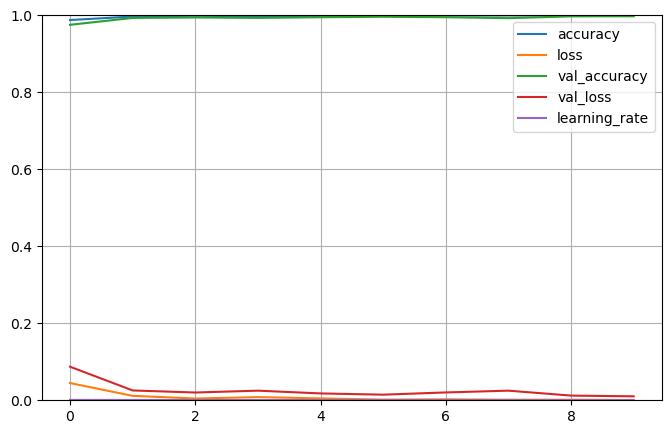

In [52]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [54]:
test_dir = pathlib.Path('C:/Users/HP/Documents/Codebasics/GTSCDS/Test')
labels = list(test_df['ClassId'])
testl = list(test_dir.glob('*.png'))
data =[]

for img in testl:
    try:
        image = cv2.imread(str(img))
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((62,62))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred_classes)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 129s 310ms/step
Test Data accuracy:  98.09976247030879


In [55]:
print(X_test.shape)


(12630, 62, 62, 3)


In [56]:
pred = model.predict(X_test)

395/395 ━━━━━━━━━━━━━━━━━━━━ 129s 328ms/step


In [57]:
cf = confusion_matrix(labels, pred_classes, normalize = 'true')

<Axes: >

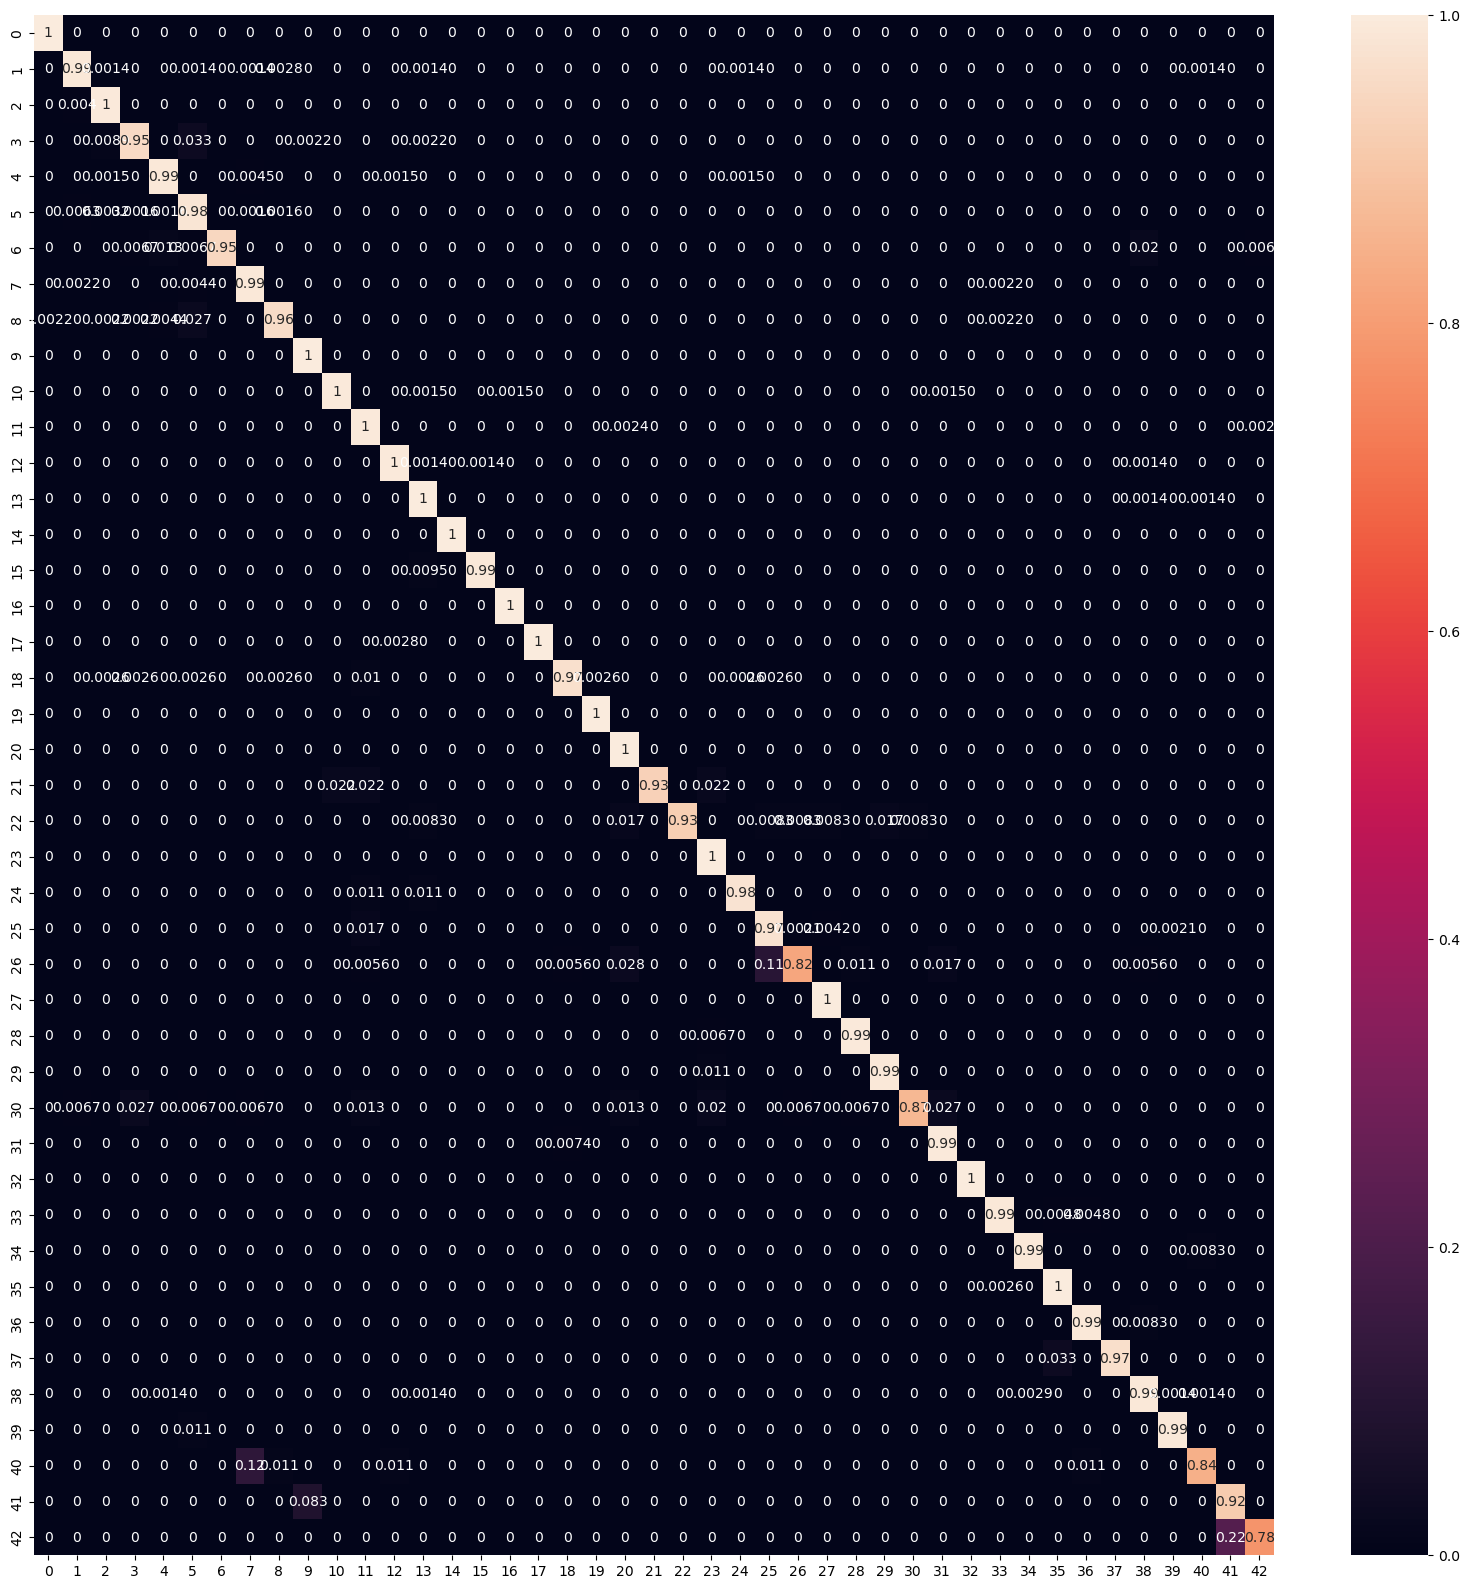

In [58]:
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [60]:
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.99      0.99      0.99       720
           2       0.99      1.00      0.99       750
           3       0.98      0.95      0.97       450
           4       0.99      0.99      0.99       660
           5       0.95      0.98      0.97       630
           6       1.00      0.95      0.97       150
           7       0.96      0.99      0.98       450
           8       0.99      0.96      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.96      1.00      0.98       420
          12       1.00      1.00      1.00       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.99      0.99       210
          16       0.99      1.00      1.00       150
          17       1.00    

Testing random Traffic Sign Images 

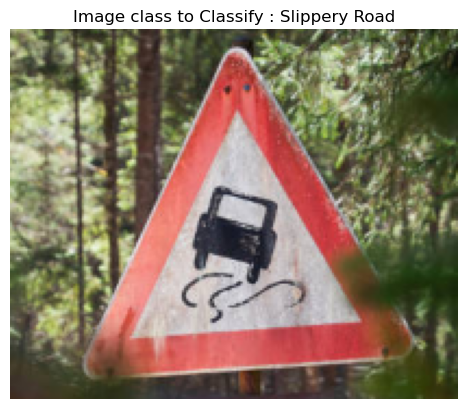

In [61]:
image = 'C:/Users/HP/Documents/Codebasics/GTSCDS/Random/' + 'slip2.png'
im = Image.open(image)
plt.imshow(im)
plt.axis('off')
plt.title(f"Image class to Classify : Slippery Road")
plt.show()

In [62]:
image = cv2.imread('C:/Users/HP/Documents/Codebasics/GTSCDS/Random/' + 'slip2.png')
data = []
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((62,62))
data.append(np.array(resize_image))

X_test = np.array(data)
X_test = X_test/255

pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [63]:
pred_classes

array([23], dtype=int64)

In [64]:
classes[pred_classes[0]]

'Slippery road'

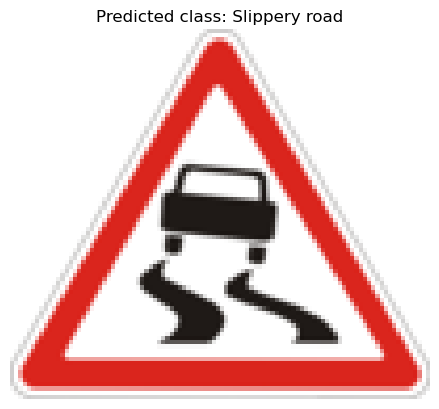

In [65]:
img = pred_classes[0]
path = list(data_dir.glob(f'Meta/{img}.png'))
img_path = str(path[0])
image = Image.open(img_path)

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted class: {classes[pred_classes[0]]}")
plt.show()